In [214]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nsepython as nse
import datetime 

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error
from sklearn.preprocessing import StandardScaler

In [215]:
start_date = datetime.date(year=2015,month=1,day=1)
start_date = start_date.strftime(format="%Y-%m-%d")
end_date = datetime.date.today()
end_date = end_date.strftime(format="%Y-%m-%d")

In [216]:
# Index names 'NIFTY 50','NIFTY BANK'
df = nse.index_history(symbol="NIFTY 50",start_date=start_date,end_date=end_date)
# Column selection and renaming
df = df[['HistoricalDate','OPEN','HIGH','LOW','CLOSE']]
df.columns = ['Date','Open','High','Low','Close']
def split_date(i):
    return i.split()[0],i.split()[1],i.split()[2]
df['Date'] = pd.to_datetime(df['Date'])
df['Day'] = df['Date'].dt.day
df['Month'] = df['Date'].dt.month
def weekno(i):
    return i.strftime("%W")
df['Week'] = df['Date'].apply(weekno)
# df['Day'] = df['Date'].apply(split_date[0])
# df['Month'] = df['Date'].apply(split_date[1])
# df['Year'] = df['Date'].apply(split_date[2])
df  = df.set_index(keys='Date')
for i in df:
    df[i] = df[i].astype(float)
df.head()

,Open,High,Low,Close,Day,Month,Week
Date,,,,,,,
2025-04-03,23150.30,23306.50,23145.80,23250.10,3.0,4.0,13.0
2025-04-02,23192.60,23350.00,23158.45,23332.35,2.0,4.0,13.0
2025-04-01,23341.10,23565.15,23136.40,23165.70,1.0,4.0,13.0
2025-03-28,23600.40,23649.20,23450.20,23519.35,28.0,3.0,12.0
2025-03-27,23433.95,23646.45,23412.20,23591.95,27.0,3.0,12.0


In [217]:
# Addressing stationarity
for i in ['Open','High','Low','Close']:
    df[f'{i}'] = round(((df[f'{i}'].diff(-1))/(df[f'{i}'].shift(-1)))*100,2)
df['Nxt_Close'] = df['Close'].shift(1)
df['Nxt_Open'] = df['Open'].shift(1)
def quarter(i):
    return np.ceil(i/3)
df['Quarter'] = df['Month'].apply(quarter)
df = df.dropna()
df = df[::-1]
df

,Open,High,Low,Close,Day,Month,Week,Nxt_Close,Nxt_Open,Quarter
Date,,,,,,,,,,
2015-01-02,0.19,1.40,0.48,1.35,2.0,1.0,0.0,-0.20,1.44,1.0
2015-01-05,1.44,0.42,0.91,-0.20,5.0,1.0,1.0,-3.00,-0.98,1.0
2015-01-06,-0.98,-1.39,-3.02,-3.00,6.0,1.0,1.0,-0.31,-2.48,1.0
2015-01-07,-2.48,-2.12,-0.57,-0.31,7.0,1.0,1.0,1.64,0.90,1.0
2015-01-08,0.90,1.13,1.26,1.64,8.0,1.0,1.0,0.61,1.15,1.0
...,...,...,...,...,...,...,...,...,...,...
2025-03-26,-0.21,-0.56,-0.63,-0.77,26.0,3.0,12.0,0.45,-1.13,1.0
2025-03-27,-1.13,-0.38,-0.17,0.45,27.0,3.0,12.0,-0.31,0.71,1.0
2025-03-28,0.71,0.01,0.16,-0.31,28.0,3.0,12.0,-1.50,-1.10,1.0


In [218]:
# Train test split
test_df = df.iloc[-540:]
train_df = df.iloc[:2000]
X_train,y_train = train_df.drop('Nxt_Close',axis=1),train_df['Nxt_Close']
X_test,y_test = test_df.drop('Nxt_Close',axis=1),test_df['Nxt_Close']

In [219]:
# Feature creation 1
def feature_creation1(df):
    for i in ['High','Low','Open','Close']: # 
        for j in ['Day','Week','Month','Quarter']:
            data = df.groupby(by=j)[i].std()
            data = dict(data)
            df[f'{i}_{j}_Std'] = df[j].map(data)
    for k in df:
        df[k] = df[k].apply(lambda i: round(i,2))
    return df

X_train = feature_creation1(X_train)
X_test = feature_creation1(X_test)
X_train


,Open,High,Low,Close,Day,Month,Week,Nxt_Open,Quarter,High_Day_Std,...,Low_Month_Std,Low_Quarter_Std,Open_Day_Std,Open_Week_Std,Open_Month_Std,Open_Quarter_Std,Close_Day_Std,Close_Week_Std,Close_Month_Std,Close_Quarter_Std
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-02,0.19,1.40,0.48,1.35,2.0,1.0,0.0,1.44,1.0,0.82,...,0.79,1.41,1.17,0.47,0.83,1.42,0.93,0.79,0.89,1.43
2015-01-05,1.44,0.42,0.91,-0.20,5.0,1.0,1.0,-0.98,1.0,0.82,...,0.79,1.41,0.95,0.88,0.83,1.42,0.87,0.98,0.89,1.43
2015-01-06,-0.98,-1.39,-3.02,-3.00,6.0,1.0,1.0,-2.48,1.0,0.88,...,0.79,1.41,1.02,0.88,0.83,1.42,0.99,0.98,0.89,1.43
2015-01-07,-2.48,-2.12,-0.57,-0.31,7.0,1.0,1.0,0.90,1.0,1.05,...,0.79,1.41,1.03,0.88,0.83,1.42,1.30,0.98,0.89,1.43
2015-01-08,0.90,1.13,1.26,1.64,8.0,1.0,1.0,1.15,1.0,0.82,...,0.79,1.41,0.91,0.88,0.83,1.42,0.85,0.98,0.89,1.43
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-01-20,-0.02,-0.05,-0.26,-0.44,20.0,1.0,3.0,0.02,1.0,1.13,...,0.79,1.41,1.03,0.84,0.83,1.42,1.37,0.86,0.89,1.43
2023-01-23,0.02,0.09,0.26,0.50,23.0,1.0,4.0,0.36,1.0,1.28,...,0.79,1.41,1.50,1.07,0.83,1.42,1.77,1.08,0.89,1.43
2023-01-24,0.36,0.21,0.08,-0.00,24.0,1.0,4.0,-0.50,1.0,0.95,...,0.79,1.41,1.09,1.07,0.83,1.42,1.38,1.08,0.89,1.43


In [220]:
# Correlation analysis 
pd.concat([X_train,y_train],axis=1).corr()
# Corr analysis remains inconclusive

,Open,High,Low,Close,Day,Month,Week,Nxt_Open,Quarter,High_Day_Std,...,Low_Quarter_Std,Open_Day_Std,Open_Week_Std,Open_Month_Std,Open_Quarter_Std,Close_Day_Std,Close_Week_Std,Close_Month_Std,Close_Quarter_Std,Nxt_Close
Open,1.000000,0.721596,0.741134,0.323261,0.001422,0.016595,0.016624,-0.062045,0.026937,-0.030758,...,-0.032256,-0.024682,-0.053395,-0.036391,-0.030001,-0.012077,-0.032556,-0.030436,-0.030029,-0.055462
High,0.721596,1.000000,0.700642,0.728907,0.012458,0.019522,0.020240,0.314044,0.033454,-0.034170,...,-0.041162,-0.031447,-0.083197,-0.048829,-0.038084,-0.021096,-0.049713,-0.039196,-0.037897,-0.033214
Low,0.741134,0.700642,1.000000,0.688276,-0.002939,0.023245,0.022793,0.319640,0.031619,-0.010184,...,-0.037397,-0.016936,-0.059788,-0.026784,-0.034498,-0.014125,-0.037262,-0.023522,-0.034815,-0.024503
Close,0.323261,0.728907,0.688276,1.000000,0.007085,0.019196,0.019388,0.622732,0.028792,-0.003925,...,-0.035205,-0.008439,-0.067237,-0.031509,-0.032511,-0.007247,-0.039418,-0.025047,-0.032446,-0.020960
Day,0.001422,0.012458,-0.002939,0.007085,1.000000,0.017680,0.099811,0.015787,0.020717,0.110567,...,-0.028142,0.169634,0.053605,-0.000862,-0.025519,0.103478,0.033868,0.003507,-0.024896,0.030666
Month,0.016595,0.019522,0.023245,0.019196,0.017680,1.000000,0.996362,0.018776,0.971846,-0.003493,...,-0.854128,0.008242,-0.310080,-0.357180,-0.896658,-0.009558,-0.414837,-0.494409,-0.935989,0.021255
Week,0.016624,0.020240,0.022793,0.019388,0.099811,0.996362,1.000000,0.020051,0.968688,0.005871,...,-0.850755,0.022425,-0.305579,-0.357351,-0.893320,-0.000931,-0.411733,-0.493672,-0.932632,0.024010
Nxt_Open,-0.062045,0.314044,0.319640,0.622732,0.015787,0.018776,0.020051,1.000000,0.027408,0.016204,...,-0.034547,0.004491,-0.058890,-0.032107,-0.031877,0.014464,-0.029718,-0.027561,-0.031527,0.322906
Quarter,0.026937,0.033454,0.031619,0.028792,0.020717,0.971846,0.968688,0.027408,1.000000,-0.001724,...,-0.876824,0.009921,-0.406480,-0.484464,-0.922334,-0.008136,-0.482178,-0.576309,-0.962576,0.029470
High_Day_Std,-0.030758,-0.034170,-0.010184,-0.003925,0.110567,-0.003493,0.005871,0.016204,-0.001724,1.000000,...,-0.002302,0.533460,0.038315,0.008810,-0.000814,0.776821,0.054335,0.009763,-0.000212,0.018834


In [221]:
# Scaling 
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train),columns=X_train.columns,index=X_train.index)
X_test = pd.DataFrame(scaler.transform(X_test),columns=X_test.columns,index=X_test.index)

rmse : 0.7395763756292442



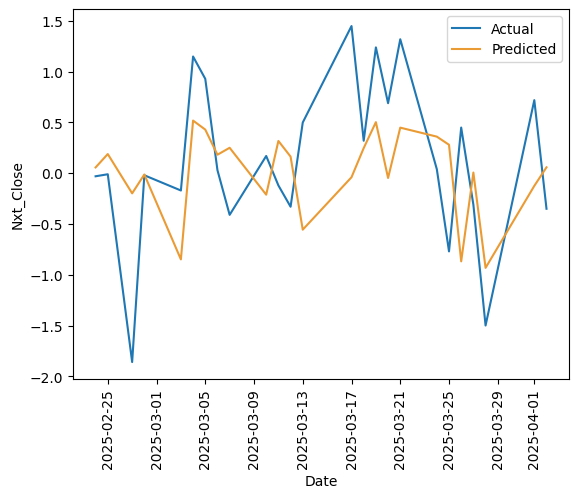

In [224]:
# Modeling
reg = RandomForestRegressor(random_state=11)
reg.fit(X_train,y_train)

y_pred = reg.predict(X_test)
y_pred = pd.Series(y_pred,index=y_test.index)

rmse = root_mean_squared_error(y_test,y_pred)
print("rmse :",rmse)
print()

sns.lineplot(y_test[-25:],label = 'Actual')
sns.lineplot(y_pred[-25:],color='#eb9b34',label = 'Predicted')
plt.xticks(rotation=90)
plt.legend()
plt.show()